<a href="https://colab.research.google.com/github/cseveriano/spatio-temporal-forecasting/blob/master/notebooks/thesis_experiments/20200824_Solar_Energy_Oahu_Univariate_Raw_Forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip3 install -U git+https://github.com/PYFTS/pyFTS
!pip3 install -U git+https://github.com/cseveriano/spatio-temporal-forecasting
!pip3 install -U hyperopt

  Cloning https://github.com/PYFTS/pyFTS to /tmp/pip-req-build-_k6erywi
  Running command git clone -q https://github.com/PYFTS/pyFTS /tmp/pip-req-build-_k6erywi
  Created wheel for pyFTS: filename=pyFTS-1.6-cp36-none-any.whl size=207416 sha256=15ccdb017b60b0fca89a93b07e794ca46bcafbcb97a5390d0b829d77cb792fd6
  Stored in directory: /tmp/pip-ephem-wheel-cache-q243jthk/wheels/e7/32/a9/230470113df5a73242a5a6d05671cb646db97abf14bbce2644
Successfully built pyFTS
  Cloning https://github.com/cseveriano/spatio-temporal-forecasting to /tmp/pip-req-build-o87z7mfv
  Running command git clone -q https://github.com/cseveriano/spatio-temporal-forecasting /tmp/pip-req-build-o87z7mfv
  Created wheel for spatio-temporal-forecasting: filename=spatio_temporal_forecasting-1.0-cp36-none-any.whl size=55633 sha256=f7a12925694257607bbf3a132f1e94b19484890345e7cba9010876153327e0e1
  Stored in directory: /tmp/pip-ephem-wheel-cache-cf925vmj/wheels/d2/1f/6f/439795864246039ef36c6a3c88edf7935c803c2cf97133066a
Succes

In [ ]:
import pandas as pd
import numpy as np
from hyperopt import hp
from spatiotemporal.util import parameter_tuning, sampling
from spatiotemporal.util import experiments as ex
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import pickle
import math
from pyFTS.benchmarks import Measures
from google.colab import files
import warnings 
warnings.filterwarnings("ignore", category=DeprecationWarning)

### Aux Functions

In [ ]:
def normalize(df):
    mindf = df.min()
    maxdf = df.max()
    return (df-mindf)/(maxdf-mindf)

def denormalize(norm, _min, _max):
    return [(n * (_max-_min)) + _min for n in norm]


### Load Dataset

In [ ]:
#Set target and input variables 
target_station = 'DH1'

#All neighbor stations with residual correlation greater than .90
neighbor_stations_80 = ['DH4','DH5','DH9','DH2','DH6','DH7']
neighbor_stations_70 = ['DH3','DH4','DH5','DH10','DH9','DH2','AP1','DH6','DH7','AP2']

In [ ]:
# read raw dataset
import pandas as pd
df = pd.read_csv('https://query.data.world/s/76ohtd4zd6a6fhiwwe742y23fiplgk')

# drop unused columns
df.drop(df.columns[df.columns.str.contains('unnamed',case = False)],axis = 1, inplace = True)
df.drop(['Time','Ioh','DH1T','AP6T','AP3','AP2.dif','AP2.dir'],axis = 1, inplace = True)

# create corrected index
ind = pd.date_range(start='2010-03-18 00:00:00', end='2011-11-01 00:00:00', closed='left', freq='10s')
ts = pd.DataFrame(index=ind)
df['Time'] = ts.between_time("05:00:00","20:00:00").index
df.set_index('Time', inplace = True)


# filter range of interest
df = df["2010-06-01":"2011-07-31"]

# Resampling
df = df.resample('10min').mean()
df = df.between_time("05:00:00","20:00:00")

In [ ]:
#Normalize Data

# Save Min-Max for Denorm
min_raw = df[target_station].min()

max_raw = df[target_station].max()

# Perform Normalization
norm_df = normalize(df)

In [ ]:
# Tuning split
tuning_df = norm_df["2010-06-01":"2010-06-30"]

norm_df = norm_df["2010-07-01":"2011-07-31"]
df = df["2010-07-01":"2011-07-31"]

### Rolling Window Validation

In [ ]:
import datetime

def getRollingWindow(index):
    pivot = index
    train_start = pivot.strftime('%Y-%m-%d')
    pivot = pivot + datetime.timedelta(days=20)
    train_end = pivot.strf
    time('%Y-%m-%d')

    pivot = pivot + datetime.timedelta(days=1)
    test_start = pivot.strftime('%Y-%m-%d')
    pivot = pivot + datetime.timedelta(days=6)
    test_end = pivot.strftime('%Y-%m-%d')
    
    return train_start, train_end, test_start, test_end

def calculate_rolling_error(cv_name, df, forecasts, order_list):
    cv_results = pd.DataFrame(columns=['Split', 'RMSE', 'SMAPE', 'U'])

    limit = df.index[-1].strftime('%Y-%m-%d')

    test_end = ""
    index = df.index[0]

    for i in np.arange(len(forecasts)):

        train_start, train_end, test_start, test_end = getRollingWindow(index)
        test = df[test_start : test_end]
    
        yhat = forecasts[i]
        order = order_list[i]
        
        rmse = Measures.rmse(test[target_station].iloc[order:], yhat[:-1])
        
        smape = Measures.smape(test[target_station].iloc[order:], yhat[:-1])
        
        res = {'Split' : index.strftime('%Y-%m-%d') ,'RMSE' : rmse, 'SMAPE' : smape}
        cv_results = cv_results.append(res, ignore_index=True)
        cv_results.to_csv(cv_name+".csv")        

        index = index + datetime.timedelta(days=7)

def get_final_forecast(norm_forecasts):
    
    forecasts_final = []
    
    for i in np.arange(len(norm_forecasts)):
        f_raw = denormalize(norm_forecasts[i], min_raw, max_raw)

        forecasts_final.append(f_raw)
        
    return forecasts_final

### Persistence

In [ ]:
def persistence_forecast(train, test, step):
    predictions = []
    
    for t in np.arange(0,len(test), step):
        yhat = [test.iloc[t]]  * step
        predictions.extend(yhat)
        
    return predictions

def rolling_cv_persistence(df, step):

    forecasts = []
    lags_list = []

    limit = df.index[-1].strftime('%Y-%m-%d')

    test_end = ""
    index = df.index[0]

    while test_end < limit :
        print("Index: ", index.strftime('%Y-%m-%d'))  

        train_start, train_end, test_start, test_end = getRollingWindow(index)
        index = index + datetime.timedelta(days=7)
        
        train = df[train_start : train_end]
        test = df[test_start : test_end]
    
        yhat = persistence_forecast(train[target_station], test[target_station], step)        
        
        lags_list.append(1)
        forecasts.append(yhat)

    return forecasts, lags_list

In [ ]:
forecasts_raw, order_list = rolling_cv_persistence(norm_df, 1)
forecasts_final = get_final_forecast(forecasts_raw)

calculate_rolling_error("rolling_cv_oahu_raw_persistence", norm_df, forecasts_final, order_list)

Index:  2010-07-01
Index:  2010-07-08
Index:  2010-07-15
Index:  2010-07-22
Index:  2010-07-29
Index:  2010-08-05
Index:  2010-08-12
Index:  2010-08-19
Index:  2010-08-26
Index:  2010-09-02
Index:  2010-09-09
Index:  2010-09-16
Index:  2010-09-23
Index:  2010-09-30
Index:  2010-10-07
Index:  2010-10-14
Index:  2010-10-21
Index:  2010-10-28
Index:  2010-11-04
Index:  2010-11-11
Index:  2010-11-18
Index:  2010-11-25
Index:  2010-12-02
Index:  2010-12-09
Index:  2010-12-16
Index:  2010-12-23
Index:  2010-12-30
Index:  2011-01-06
Index:  2011-01-13
Index:  2011-01-20
Index:  2011-01-27
Index:  2011-02-03
Index:  2011-02-10
Index:  2011-02-17
Index:  2011-02-24
Index:  2011-03-03
Index:  2011-03-10
Index:  2011-03-17
Index:  2011-03-24
Index:  2011-03-31
Index:  2011-04-07
Index:  2011-04-14
Index:  2011-04-21
Index:  2011-04-28
Index:  2011-05-05
Index:  2011-05-12
Index:  2011-05-19
Index:  2011-05-26
Index:  2011-06-02
Index:  2011-06-09
Index:  2011-06-16
Index:  2011-06-23
Index:  2011

In [ ]:
files.download('rolling_cv_oahu_raw_persistence.csv')

### Univariate MLP

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.constraints import maxnorm
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.normalization import BatchNormalization

In [ ]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

#### MLP Tuning

In [ ]:
mlp_space = {'choice':

   hp.choice('num_layers',
             [
                 {'layers': 'two',
                 },

                 {'layers': 'three',

                   'units3': hp.choice('units3', [8, 16, 64, 128, 256, 512]),
                   'dropout3': hp.choice('dropout3', [0, 0.25, 0.5, 0.75])
                  }

             ]),
   'units1': hp.choice('units1', [8, 16, 64, 128, 256, 512]),
   'units2': hp.choice('units2', [8, 16, 64, 128, 256, 512]),

   'dropout1': hp.choice('dropout1', [0, 0.25, 0.5, 0.75]),
   'dropout2': hp.choice('dropout2', [0, 0.25, 0.5, 0.75]),

   'batch_size': hp.choice('batch_size', [28, 64, 128, 256, 512]),
   'order': hp.choice('order', [1, 2, 4, 8]),
   'input': hp.choice('input', [target_station]),
   'output': hp.choice('output', [target_station]),
   'epochs': hp.choice('epochs', [100, 200, 300])}


In [ ]:
def mlp_tuning(train_df, test_df, params):
    _input = [target_station]
    _nlags = params['order']
    _epochs = params['epochs']
    _batch_size = params['batch_size']
    nfeat = len(_input)
    nsteps = params.get('step',1)
    nobs = _nlags * nfeat

    output_index = -nfeat*nsteps

    train_reshaped_df = series_to_supervised(train_df[_input].values, n_in=_nlags, n_out=nsteps)
    train_X, train_Y = train_reshaped_df.iloc[:, :nobs].values, train_reshaped_df.iloc[:, output_index:].values

    test_reshaped_df = series_to_supervised(test_df[_input].values, n_in=_nlags, n_out=nsteps)
    test_X, test_Y = test_reshaped_df.iloc[:, :nobs].values, test_reshaped_df.iloc[:, output_index:].values

    # design network
    model = Sequential()
    model.add(Dense(params['units1'], activation='relu', input_dim=train_X.shape[1]))
    model.add(Dense(params['units2'], activation='relu'))
    if params['choice']['layers'] == 'three':
      model.add(Dense(params['choice']['units3'], activation='relu'))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')

    # includes the call back object
    model.fit(train_X, train_Y, epochs=_epochs, batch_size=_batch_size, verbose=False, shuffle=False)

    # predict the test set
    forecast = model.predict(test_X, verbose=False)

    forecast = [f[0] for f in forecast]

    return forecast


In [ ]:
methods = []
methods.append(("EXP_OAHU_MLP", mlp_tuning, mlp_space))
train_split = 0.6
parameter_tuning.run_search(methods, tuning_df, train_split, Measures.rmse, max_evals=30, resample=None)

Running experiment: EXP_OAHU_MLP
{'batch_size': 64, 'choice': {'dropout3': 0.25, 'layers': 'three', 'units3': 128}, 'dropout1': 0.25, 'dropout2': 0.25, 'epochs': 100, 'input': 'DH1', 'order': 2, 'output': 'DH1', 'units1': 128, 'units2': 256}
Error : 0.0953588519355079
{'batch_size': 128, 'choice': {'dropout3': 0, 'layers': 'three', 'units3': 8}, 'dropout1': 0.75, 'dropout2': 0, 'epochs': 300, 'input': 'DH1', 'order': 2, 'output': 'DH1', 'units1': 64, 'units2': 64}
Error : 0.09356564634991042
{'batch_size': 128, 'choice': {'dropout3': 0.5, 'layers': 'three', 'units3': 8}, 'dropout1': 0.25, 'dropout2': 0.25, 'epochs': 100, 'input': 'DH1', 'order': 4, 'output': 'DH1', 'units1': 256, 'units2': 16}
Error : 0.09430287835863217
{'batch_size': 28, 'choice': {'dropout3': 0.25, 'layers': 'three', 'units3': 16}, 'dropout1': 0.75, 'dropout2': 0.75, 'epochs': 100, 'input': 'DH1', 'order': 8, 'output': 'DH1', 'units1': 8, 'units2': 64}
Error : 0.09364397251454364
{'batch_size': 28, 'choice': {'layer

Best params: \
\
mlp raw: \
{'batch_size': 28, 'choice': {'dropout3': 0.75, 'layers': 'three', 'units3': 16}, 'dropout1': 0, 'dropout2': 0.25, 'epochs': 300, 'input': 'DH1', 'order': 2, 'output': 'DH1', 'units1': 256, 'units2': 256} \


#### MLP Forecasting

In [ ]:
def mlp_forecast(train_df, test_df, params):


    _input = [target_station]
    _nlags = params['order']
    _epochs = params['epochs']
    _batch_size = params['batch_size']
    nfeat = len(_input)
    nsteps = params.get('step',1)
    nobs = _nlags * nfeat

    output_index = -nfeat*nsteps


    train_reshaped_df = series_to_supervised(train_df[_input].values, n_in=_nlags, n_out=nsteps)
    train_X, train_Y = train_reshaped_df.iloc[:, :nobs].values, train_reshaped_df.iloc[:, output_index:].values

    test_reshaped_df = series_to_supervised(test_df[_input].values, n_in=_nlags, n_out=nsteps)
    test_X, test_Y = test_reshaped_df.iloc[:, :nobs].values, test_reshaped_df.iloc[:, output_index:].values
    
    # design network
    model = Sequential()
    model.add(Dense(params['units1'], activation='relu', input_dim=train_X.shape[1]))
    model.add(Dense(params['units2'], activation='relu'))
    if params['choice']['layers'] == 'three':
      model.add(Dense(params['choice']['units3'], activation='relu'))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')


    # fit network
    model.fit(train_X, train_Y, epochs=_epochs, batch_size=1000, verbose=False, shuffle=False)
    
    forecast = model.predict(test_X)
    
    fcst = [f[0] for f in forecast]

    return fcst

def rolling_cv_mlp_uni(df, params):
    
    lags_list = []
    forecasts = []

    limit = df.index[-1].strftime('%Y-%m-%d')

    test_end = ""
    index = df.index[0]

    while test_end < limit :
        print("Index: ", index.strftime('%Y-%m-%d'))  

        train_start, train_end, test_start, test_end = getRollingWindow(index)
        index = index + datetime.timedelta(days=7)
        
        train = df[train_start : train_end]
        test = df[test_start : test_end]


        # Perform forecast
        yhat = mlp_forecast(train[[target_station]], test[[target_station]], params)
        
        yhat.append(yhat[-1]) #para manter o formato do vetor de metricas
        
        lags_list.append(params['order'])
        forecasts.append(yhat)

    return forecasts, lags_list

In [ ]:
# Enter best params
params_raw = {'batch_size': 28, 'choice': {'dropout3': 0.75, 'layers': 'three', 'units3': 16}, 'dropout1': 0, 'dropout2': 0.25, 'epochs': 300, 'input': 'DH1', 'order': 2, 'output': 'DH1', 'units1': 256, 'units2': 256}

forecasts_raw, order_list = rolling_cv_mlp_uni(norm_df, params_raw)

forecasts_final = get_final_forecast(forecasts_raw)
calculate_rolling_error("rolling_cv_oahu_raw_mlp_uni", df, forecasts_final, order_list)

Index:  2010-07-01
Index:  2010-07-08
Index:  2010-07-15
Index:  2010-07-22
Index:  2010-07-29
Index:  2010-08-05
Index:  2010-08-12
Index:  2010-08-19
Index:  2010-08-26
Index:  2010-09-02
Index:  2010-09-09
Index:  2010-09-16
Index:  2010-09-23
Index:  2010-09-30
Index:  2010-10-07
Index:  2010-10-14
Index:  2010-10-21
Index:  2010-10-28
Index:  2010-11-04
Index:  2010-11-11
Index:  2010-11-18
Index:  2010-11-25
Index:  2010-12-02
Index:  2010-12-09
Index:  2010-12-16
Index:  2010-12-23
Index:  2010-12-30
Index:  2011-01-06
Index:  2011-01-13
Index:  2011-01-20
Index:  2011-01-27
Index:  2011-02-03
Index:  2011-02-10
Index:  2011-02-17
Index:  2011-02-24
Index:  2011-03-03
Index:  2011-03-10
Index:  2011-03-17
Index:  2011-03-24
Index:  2011-03-31
Index:  2011-04-07
Index:  2011-04-14
Index:  2011-04-21
Index:  2011-04-28
Index:  2011-05-05
Index:  2011-05-12
Index:  2011-05-19
Index:  2011-05-26
Index:  2011-06-02
Index:  2011-06-09
Index:  2011-06-16
Index:  2011-06-23
Index:  2011

In [ ]:
files.download('rolling_cv_oahu_raw_mlp_uni.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Conventional (Song and Chissom) FTS

In [ ]:
from pyFTS.partitioners import Grid, Entropy, Util as pUtil
from pyFTS.models import song

#### FTS Parameter Tuning

In [ ]:
fts_space = {'partitioner': hp.choice('partitioner', [Grid.GridPartitioner, Entropy.EntropyPartitioner]),
        'npartitions': hp.choice('npartitions', [10, 50,100]),
        'order': hp.choice('order', [1]),
        'input': hp.choice('input', [target_station]),
        'output': hp.choice('output', [target_station])}

def fts_forecast(train_df, test_df, params):
    _partitioner = params['partitioner']
    _npartitions = params['npartitions']
    _order = 1
    _input = params['input']
    _step = params.get('step',1)

    fuzzy_sets = _partitioner(data=train_df[_input].values, npart=_npartitions)
    model = song.ConventionalFTS(partitioner=fuzzy_sets)

    model.fit(train_df[_input].values)
    forecast = model.predict(test_df[_input].values, steps_ahead=_step)

    return forecast[:-1]

In [ ]:
methods = []
methods.append(("EXP_OAHU_FTS", fts_forecast, fts_space))
train_split = 0.6
parameter_tuning.run_search(methods, tuning_df, train_split, Measures.rmse, max_evals=30, resample=None)

Running experiment: EXP_OAHU_FTS
{'input': 'DH1', 'npartitions': 50, 'order': 1, 'output': 'DH1', 'partitioner': <class 'pyFTS.partitioners.Grid.GridPartitioner'>}
Error : 0.2508915959411362
{'input': 'DH1', 'npartitions': 50, 'order': 1, 'output': 'DH1', 'partitioner': <class 'pyFTS.partitioners.Grid.GridPartitioner'>}
Error : 0.2508915959411362
{'input': 'DH1', 'npartitions': 100, 'order': 1, 'output': 'DH1', 'partitioner': <class 'pyFTS.partitioners.Entropy.EntropyPartitioner'>}
Error : 0.2497829334946225
{'input': 'DH1', 'npartitions': 50, 'order': 1, 'output': 'DH1', 'partitioner': <class 'pyFTS.partitioners.Grid.GridPartitioner'>}
Error : 0.2508915959411362
{'input': 'DH1', 'npartitions': 50, 'order': 1, 'output': 'DH1', 'partitioner': <class 'pyFTS.partitioners.Entropy.EntropyPartitioner'>}
Error : 0.24447862186748
{'input': 'DH1', 'npartitions': 10, 'order': 1, 'output': 'DH1', 'partitioner': <class 'pyFTS.partitioners.Grid.GridPartitioner'>}
Error : 0.18625586427848095
{'input

Best params: \
\
FTS Raw: \
{'input': 'DH1', 'npartitions': 10, 'order': 1, 'output': 'DH1', 'partitioner': <class 'pyFTS.partitioners.Grid.GridPartitioner'>} \


#### FTS Forecasting

In [ ]:
from pyFTS.partitioners import Grid, Entropy, Util as pUtil
from pyFTS.models import song


def rolling_cv_fts(df, params):

    _order = params['order']

    forecasts = []
    order_list = []

    limit = df.index[-1].strftime('%Y-%m-%d')

    test_end = ""
    index = df.index[0]

    while test_end < limit :
        print("Index: ", index.strftime('%Y-%m-%d'))  

        train_start, train_end, test_start, test_end = getRollingWindow(index)
        index = index + datetime.timedelta(days=7)
        
        train = df[train_start : train_end]
        test = df[test_start : test_end]

        # Perform forecast
        yhat = fts_forecast(train, test, params)
        yhat.append(yhat[-1]) #para manter o formato do vetor de metricas
        
        order_list.append(_order)
        forecasts.append(yhat)

    return forecasts, order_list

In [ ]:
params_raw = {'input': 'DH1', 'npartitions': 10, 'order': 1, 'output': 'DH1', 'partitioner': Grid.GridPartitioner}


forecasts_raw, order_list = rolling_cv_fts(norm_df, params_raw)

forecasts_final = get_final_forecast(forecasts_raw)
calculate_rolling_error("rolling_cv_oahu_raw_fts", df, forecasts_final, order_list)

Index:  2010-07-01
Index:  2010-07-08
Index:  2010-07-15
Index:  2010-07-22
Index:  2010-07-29
Index:  2010-08-05
Index:  2010-08-12
Index:  2010-08-19
Index:  2010-08-26
Index:  2010-09-02
Index:  2010-09-09
Index:  2010-09-16
Index:  2010-09-23
Index:  2010-09-30
Index:  2010-10-07
Index:  2010-10-14
Index:  2010-10-21
Index:  2010-10-28
Index:  2010-11-04
Index:  2010-11-11
Index:  2010-11-18
Index:  2010-11-25
Index:  2010-12-02
Index:  2010-12-09
Index:  2010-12-16
Index:  2010-12-23
Index:  2010-12-30
Index:  2011-01-06
Index:  2011-01-13
Index:  2011-01-20
Index:  2011-01-27
Index:  2011-02-03
Index:  2011-02-10
Index:  2011-02-17
Index:  2011-02-24
Index:  2011-03-03
Index:  2011-03-10
Index:  2011-03-17
Index:  2011-03-24
Index:  2011-03-31
Index:  2011-04-07
Index:  2011-04-14
Index:  2011-04-21
Index:  2011-04-28
Index:  2011-05-05
Index:  2011-05-12
Index:  2011-05-19
Index:  2011-05-26
Index:  2011-06-02
Index:  2011-06-09
Index:  2011-06-16
Index:  2011-06-23
Index:  2011

In [ ]:
files.download('rolling_cv_oahu_raw_fts.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### High Order FTS

In [ ]:
from pyFTS.partitioners import Grid, Entropy, Util as pUtil
from pyFTS.models import hofts

#### HOFTS Parameter Tuning

In [ ]:
hofts_space = {'partitioner': hp.choice('partitioner', [Grid.GridPartitioner, Entropy.EntropyPartitioner]),
        'npartitions': hp.choice('npartitions', [10, 50,100]),
        'order': hp.choice('order', [1,2]),
        'input': hp.choice('input', [target_station]),
        'output': hp.choice('output', [target_station])}

def hofts_forecast(train_df, test_df, params):
    _partitioner = params['partitioner']
    _npartitions = params['npartitions']
    _order = params['order']
    _input = params['input']
    _step = params.get('step',1)

    fuzzy_sets = _partitioner(data=train_df[_input].values, npart=_npartitions)
    model = hofts.HighOrderFTS(order=_order)

    model.fit(train_df[_input].values, order=_order, partitioner=fuzzy_sets)
    forecast = model.predict(test_df[_input].values, steps_ahead=_step)

    return forecast

In [ ]:
methods = []
methods.append(("EXP_OAHU_HOFTS", hofts_forecast, hofts_space))
train_split = 0.6
parameter_tuning.run_search(methods, tuning_df, train_split, Measures.rmse, max_evals=30, resample=None)

Best params: \
\
HOFTS raw: \
{'input': 'DH1', 'npartitions': 100, 'order': 1, 'output': 'DH1', 'partitioner': <class 'pyFTS.partitioners.Grid.GridPartitioner'>} \


In [ ]:
from pyFTS.partitioners import Grid, Entropy, Util as pUtil
from pyFTS.models import hofts


def rolling_cv_hofts(df, params):

    _order = params['order']

    forecasts = []
    order_list = []

    limit = df.index[-1].strftime('%Y-%m-%d')

    test_end = ""
    index = df.index[0]

    while test_end < limit :
        print("Index: ", index.strftime('%Y-%m-%d'))  

        train_start, train_end, test_start, test_end = getRollingWindow(index)
        index = index + datetime.timedelta(days=7)
        
        train = df[train_start : train_end]
        test = df[test_start : test_end]

        # Perform forecast
        yhat = hofts_forecast(train, test, params)
        yhat.append(yhat[-1]) #para manter o formato do vetor de metricas
        
        order_list.append(_order)
        forecasts.append(yhat)

    return forecasts, order_list

In [ ]:
params_raw = {'input': 'DH1', 'npartitions': 100, 'order': 1, 'output': 'DH1', 'partitioner': Grid.GridPartitioner}


forecasts_raw, order_list = rolling_cv_hofts(norm_df, params_raw)

forecasts_final = get_final_forecast(forecasts_raw)
calculate_rolling_error("rolling_cv_oahu_raw_hofts", df, forecasts_final, order_list)

In [ ]:
files.download('rolling_cv_oahu_raw_hofts.csv')

### NSFTS

In [ ]:
from pyFTS.models.nonstationary import common, perturbation, partitioners as nspart
from pyFTS.models.nonstationary import nsfts, util as nsUtil

#### Parameter Tuning

In [ ]:
nsfts_space = {'npartitions': hp.choice('npartitions', [10, 30, 50, 100, 150]),
        'order': hp.choice('order', [1]),
        'input': hp.choice('input', [target_station]),
        'output': hp.choice('output', [target_station])}

def nsfts_forecast(train_df, test_df, params):
    _npartitions = params['npartitions']
    _order = params['order']
    _input = params['input']
    _step = params.get('step',1)
    
    nsfs = nspart.simplenonstationary_gridpartitioner_builder(data=train_df[_input].values, npart=_npartitions, transformation=None)
    model = nsfts.NonStationaryFTS(partitioner=nsfs, order=_order)
    
    model.fit(train_df[_input].values)

    forecast = model.predict(test_df[_input].values)
    forecast = forecast[:-1]
    return forecast

In [ ]:
methods = []
methods.append(("EXP_OAHU_NSFTS", nsfts_forecast, nsfts_space))
train_split = 0.6
parameter_tuning.run_search(methods, tuning_df, train_split, Measures.rmse, max_evals=10, resample=None)

Best params: \
\
NSFTS raw: \
{'input': 'DH1', 'npartitions': 150, 'order': 1, 'output': 'DH1'} \


#### NSFTS Forecasting

In [ ]:
def rolling_cv_nsfts(df, params):
    
    forecasts = []
    order_list = []

    _npartitions = params['npartitions']
    _order = params['order']
    _input = params['input']
    _step = params.get('step',1)

    limit = df.index[-1].strftime('%Y-%m-%d')

    test_end = ""
    index = df.index[0]
    first_time = True

    while test_end < limit :
        print("Index: ", index.strftime('%Y-%m-%d'))  

        train_start, train_end, test_start, test_end = getRollingWindow(index)
        index = index + datetime.timedelta(days=7)
        
        train = df[train_start : train_end]
        test = df[test_start : test_end]

        # Perform forecast

        # In the first time, the model is trained. 
        # For the next iterations, training subset is used to evolve the model
        if first_time:
          nsfs = nspart.simplenonstationary_gridpartitioner_builder(data=train[_input].values, npart=_npartitions, transformation=None)
          model = nsfts.NonStationaryFTS(partitioner=nsfs, order=_order)
          model.fit(train[_input].values)
          first_time = False

        forecast = model.predict(test[_input].values)
        #forecast = forecast[:-1]
        
        order_list.append(params['order'])
        forecasts.append(forecast)

    return forecasts, order_list

In [ ]:
params_raw = {'input': 'DH1', 'npartitions': 150, 'order': 1, 'output': 'DH1'}


forecasts_raw, order_list = rolling_cv_nsfts(norm_df, params_raw)

forecasts_final = get_final_forecast(forecasts_raw)
calculate_rolling_error("rolling_cv_oahu_raw_nsfts", df, forecasts_final, order_list)

Index:  2010-07-01
Index:  2010-07-08
Index:  2010-07-15
Index:  2010-07-22
Index:  2010-07-29
Index:  2010-08-05
Index:  2010-08-12
Index:  2010-08-19
Index:  2010-08-26
Index:  2010-09-02
Index:  2010-09-09
Index:  2010-09-16
Index:  2010-09-23
Index:  2010-09-30
Index:  2010-10-07
Index:  2010-10-14
Index:  2010-10-21
Index:  2010-10-28
Index:  2010-11-04
Index:  2010-11-11
Index:  2010-11-18
Index:  2010-11-25
Index:  2010-12-02
Index:  2010-12-09
Index:  2010-12-16
Index:  2010-12-23
Index:  2010-12-30
Index:  2011-01-06
Index:  2011-01-13
Index:  2011-01-20
Index:  2011-01-27
Index:  2011-02-03
Index:  2011-02-10
Index:  2011-02-17
Index:  2011-02-24
Index:  2011-03-03
Index:  2011-03-10
Index:  2011-03-17
Index:  2011-03-24
Index:  2011-03-31
Index:  2011-04-07
Index:  2011-04-14
Index:  2011-04-21
Index:  2011-04-28
Index:  2011-05-05
Index:  2011-05-12
Index:  2011-05-19
Index:  2011-05-26
Index:  2011-06-02
Index:  2011-06-09
Index:  2011-06-16
Index:  2011-06-23
Index:  2011

In [ ]:
files.download('rolling_cv_oahu_raw_nsfts.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Results Analysis

In [ ]:
files.upload()

Saving rolling_cv_oahu_raw_hofts.csv to rolling_cv_oahu_raw_hofts.csv


{'rolling_cv_oahu_raw_hofts.csv': b',Split,RMSE,SMAPE,U\n0,2010-07-01,138.5627545168579,28.136966495670237,\n1,2010-07-08,136.7411239024452,28.01264557633985,\n2,2010-07-15,126.98547045449074,27.789587681193822,\n3,2010-07-22,126.92204886549915,28.443001853639394,\n4,2010-07-29,132.94553240268968,28.96144078185361,\n5,2010-08-05,129.49364446046184,29.432287516305873,\n6,2010-08-12,130.47063416255546,30.354223680218617,\n7,2010-08-19,147.80968462249274,33.06475072480346,\n8,2010-08-26,118.72569135861349,32.925060965206136,\n9,2010-09-02,129.5306060440745,33.798803731689176,\n10,2010-09-09,125.77821254080901,35.00004479521626,\n11,2010-09-16,109.2644672818261,32.652451479255,\n12,2010-09-23,99.18953708072584,32.80659930064796,\n13,2010-09-30,99.84426818245092,34.42406404390011,\n14,2010-10-07,109.06476485545652,35.89145198379658,\n15,2010-10-14,100.69420199266067,35.96548036771197,\n16,2010-10-21,86.18741477793613,36.43155950941707,\n17,2010-10-28,90.23104360661313,36.760426062007646,\n1

In [ ]:
!ls

In [ ]:
pd.options.display.float_format = '{:.4f}'.format

In [ ]:
def createBoxplot(filename, data, xticklabels, ylabel):
    # Create a figure instance
    fig = plt.figure(1, figsize=(9, 6))

    # Create an axes instance
    ax = fig.add_subplot(111)

    # Create the boxplot
    bp = ax.boxplot(data, patch_artist=True)
    
    ## change outline color, fill color and linewidth of the boxes
    for box in bp['boxes']:
        # change outline color
        box.set( color='#7570b3', linewidth=2)
        # change fill color
        box.set( facecolor = '#AACCFF' )

    ## change color and linewidth of the whiskers
    for whisker in bp['whiskers']:
        whisker.set(color='#7570b3', linewidth=2)

    ## change color and linewidth of the caps
    for cap in bp['caps']:
        cap.set(color='#7570b3', linewidth=2)

    ## change color and linewidth of the medians
    for median in bp['medians']:
        median.set(color='#FFE680', linewidth=2)

    ## change the style of fliers and their fill
    for flier in bp['fliers']:
        flier.set(marker='o', color='#e7298a', alpha=0.5)
    
    ## Custom x-axis labels
    ax.set_xticklabels(xticklabels)
    ax.set_ylabel(ylabel)
    plt.show()
    fig.savefig(filename, bbox_inches='tight')

In [ ]:
hofts_results = pd.read_csv("rolling_cv_oahu_raw_hofts.csv")
mlp_results = pd.read_csv("rolling_cv_oahu_raw_mlp_uni.csv")
fts_results = pd.read_csv("rolling_cv_oahu_raw_fts.csv")
nsfts_results = pd.read_csv("rolling_cv_oahu_raw_nsfts.csv")
persistence_results = pd.read_csv("rolling_cv_oahu_raw_persistence.csv")

#### RMSE

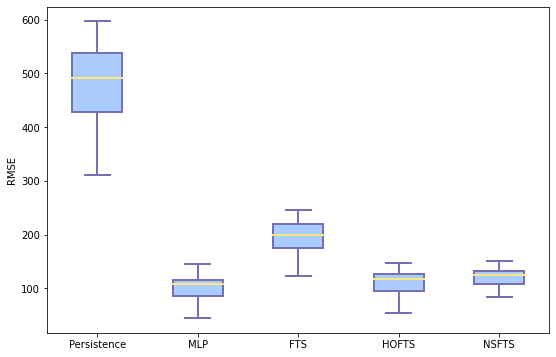

In [ ]:
metric = 'RMSE'
results_data = [persistence_results[metric],mlp_results[metric], fts_results[metric], hofts_results[metric], nsfts_results[metric]]
xticks = ['Persistence','MLP','FTS','HOFTS','NSFTS']

ylab = 'RMSE'
createBoxplot("nsfts_boxplot_rmse_oahu", results_data, xticks, ylab)

In [ ]:
metric = 'RMSE'
rmse_df = pd.DataFrame(columns=['Persistence','MLP','FTS', 'HOFTS','NSFTS'])

rmse_df["Persistence"] = persistence_results[metric]
rmse_df["MLP"] = mlp_results[metric]
rmse_df["FTS"] = fts_results[metric]
rmse_df["HOFTS"] = hofts_results[metric]
rmse_df["NSFTS"] = nsfts_results[metric]

In [ ]:
print("Mean")
print(rmse_df.mean())
print("std")
print(rmse_df.std())

Mean
Persistence   477.0410
MLP           101.8070
FTS           194.3235
HOFTS         110.4386
NSFTS         120.7854
dtype: float64
std
Persistence   71.6699
MLP           20.7889
FTS           32.3318
HOFTS         21.0441
NSFTS         16.5486
dtype: float64


#### SMAPE

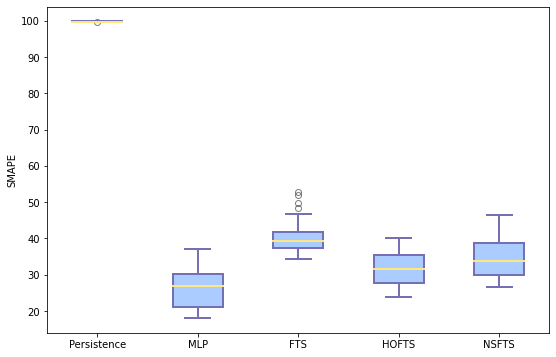

In [ ]:
metric = 'SMAPE'
results_data = [persistence_results[metric],mlp_results[metric], fts_results[metric], hofts_results[metric], nsfts_results[metric]]
xticks = ['Persistence','MLP','FTS','HOFTS','NSFTS']

ylab = 'SMAPE'
createBoxplot("nsfts_boxplot_smape_oahu", results_data, xticks, ylab)

In [ ]:
metric = 'SMAPE'
smape_df = pd.DataFrame(columns=['Persistence','MLP','FTS','HOFTS','NSFTS'])

smape_df["Persistence"] = persistence_results[metric]
smape_df["MLP"] = mlp_results[metric]
smape_df["FTS"] = fts_results[metric]
smape_df["HOFTS"] = hofts_results[metric]
smape_df["NSFTS"] = nsfts_results[metric]

In [ ]:
print("Mean")
print(smape_df.mean())
print("std")
print(smape_df.std())

Mean
Persistence   99.7761
MLP           26.2851
FTS           40.3185
HOFTS         31.4765
NSFTS         34.2836
dtype: float64
std
Persistence   0.0556
MLP           5.3700
FTS           4.0949
HOFTS         4.7601
NSFTS         5.2922
dtype: float64
